# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import optuna
import pickle
import optuna_integration

pd.set_option('display.max_columns', None)

## Trying to visualise the data

In [2]:
df = pd.read_csv('../data/final_df.csv').drop('Unnamed: 0', axis=1)
df.drop(['LCLid', 'date_year', 'date_month', 'date_day', 'moonPhase'], axis=1, inplace=True)

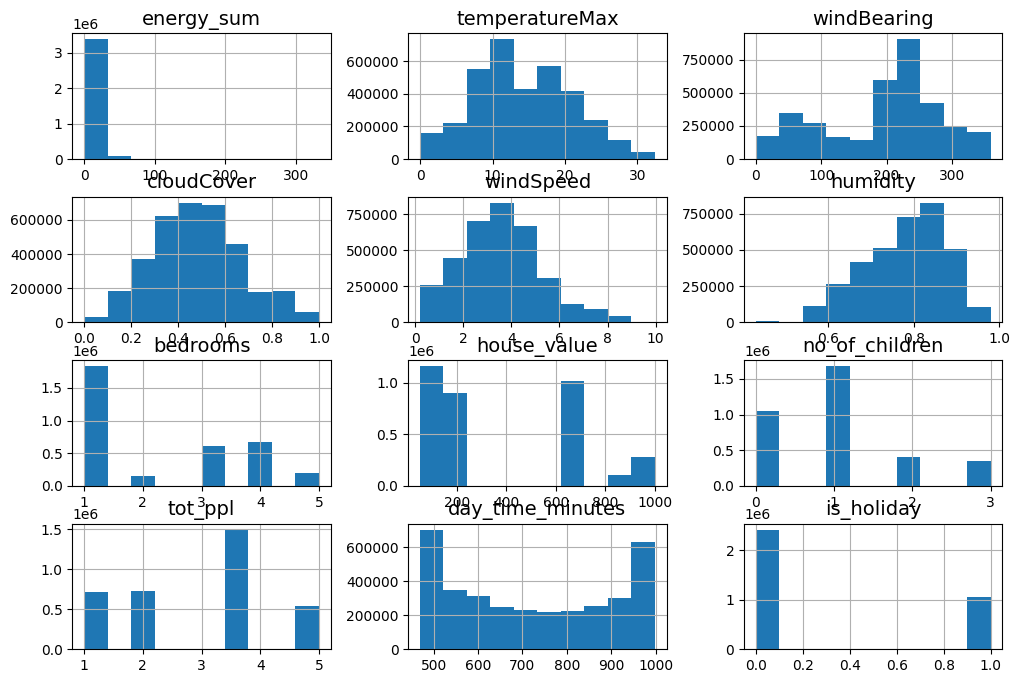

In [3]:
# checking distribution of data
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=10, figsize=(12, 8))
plt.show()

<Axes: >

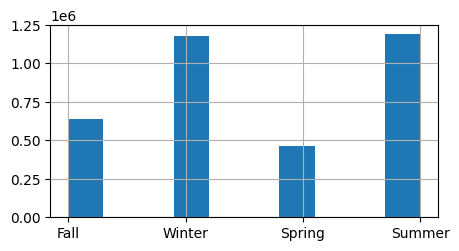

In [4]:
df['season'].hist(figsize=(5,2.5))

<Axes: >

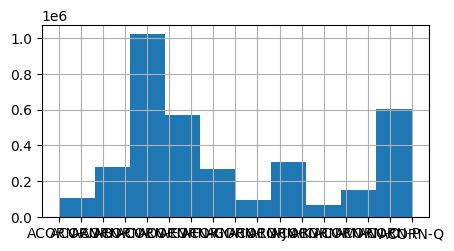

In [5]:
df['acorn'].hist(figsize=(5,2.5))

# Creating the model

## Test train split

We are going to strategically split test and train data on acorn and season

In [6]:
# creating a combination of season and acorn columns
df['strat_col'] = df['season'] + '_' + df['acorn']
df.drop('acorn', axis=1, inplace=True)
sss = StratifiedShuffleSplit(test_size = 0.2, n_splits=2, random_state=40)


In [7]:
for train_index, test_index in sss.split(df, df['strat_col']):
    strat_train_set = df.loc[train_index].reset_index(drop=True)
    strat_test_set = df.loc[test_index].reset_index(drop=True)

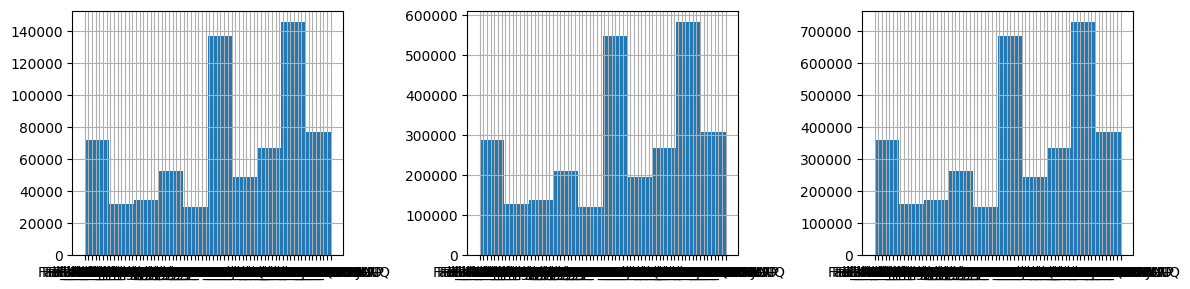

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
strat_test_set['strat_col'].sort_values().hist(ax = axes[0])
strat_train_set['strat_col'].sort_values().hist(ax = axes[1])
df['strat_col'].sort_values().hist(ax=axes[2])
# to prevent overlap adjusting the layout
plt.tight_layout()
plt.show()

## train - validation

In [9]:
# creating a combination of season and acorn columns
sss = StratifiedShuffleSplit(test_size = 0.2, n_splits=2, random_state=40)

for train_index, test_index in sss.split(strat_train_set, strat_train_set['strat_col']):
    train = strat_train_set.loc[train_index].reset_index(drop=True)
    validate = strat_train_set.loc[test_index].reset_index(drop=True)

## Outliers

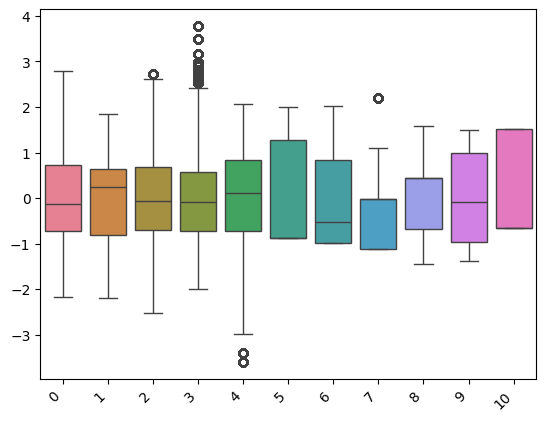

In [10]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'number']

sns.boxplot(data = std_scaler.fit_transform(strat_train_set[strat_train_set.select_dtypes(include=numerics).columns].drop('energy_sum', axis=1)))
plt.xticks(rotation=45, ha="right")
plt.show()

In [11]:
def detect_and_remove_outliers(data, features): 
    
    _data = data
    
    for feature in features:
        # Calculate Z-scores     
        z_scores = stats.zscore(data[feature])  
        # Identify outliers     
        outliers = (z_scores > 3) | (z_scores < -3)     
        
        # Remove outliers   
        _data = data
        data = data[~outliers]      
        
        # Print outlier information     
        number_of_outliers = len(_data[outliers])     
        percentage_of_outliers = round(number_of_outliers / len(_data) * 100, 2)     
        if len(_data[outliers] != 0):
            print(f"Outlier of {feature} are anything outside this range: ({z_scores.min()},{z_scores.max()})")  
            print(f"The earlier min, max were: ({_data[feature].min()},{_data[feature].max()})")
            print(f"The current min, max are: ({data[feature].min()},{data[feature].max()})")
            print(f"Outliers out of total = {len(_data)} are: {number_of_outliers}")  
            print(f'percentage of outliers are {percentage_of_outliers}')
            print()
        
    return _data  

In [12]:
strat_train_set = detect_and_remove_outliers(strat_train_set, strat_train_set.select_dtypes(include=numerics).columns)
train = detect_and_remove_outliers(train, train.select_dtypes(include=numerics).columns)

Outlier of energy_sum are anything outside this range: (-1.1132194639509876,35.51685156209716)
The earlier min, max were: (0.0,332.5560009999998)
The current min, max are: (0.0,37.3420004)
Outliers out of total = 2780012 are: 50744
percentage of outliers are 1.83

Outlier of windSpeed are anything outside this range: (-2.0036591896570872,3.7808247809310895)
The earlier min, max were: (0.2,9.96)
The current min, max are: (0.2,8.64)
Outliers out of total = 2729268 are: 8168
percentage of outliers are 0.3

Outlier of humidity are anything outside this range: (-3.5893009220812586,2.066506205316636)
The earlier min, max were: (0.43,0.98)
The current min, max are: (0.49,0.98)
Outliers out of total = 2721100 are: 8437
percentage of outliers are 0.31

Outlier of energy_sum are anything outside this range: (-1.1126646783976266,35.505464812429324)
The earlier min, max were: (0.0,332.5560009999998)
The current min, max are: (0.0,37.35000000000001)
Outliers out of total = 2224009 are: 40458
percen

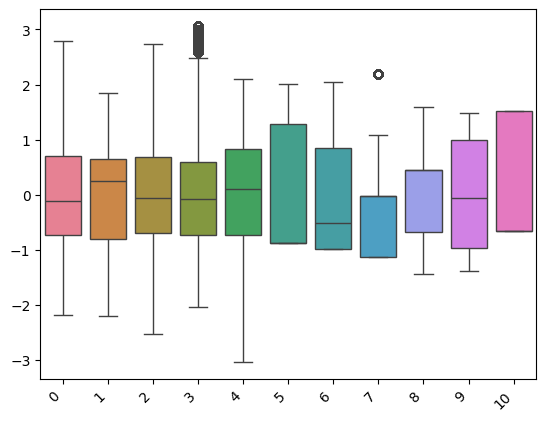

In [13]:
sns.boxplot(data = std_scaler.fit_transform(strat_train_set[strat_train_set.select_dtypes(include=numerics).columns].drop('energy_sum', axis=1)))
plt.xticks(rotation=45, ha="right")
plt.show()

In [14]:
X_strat_train, X_strat_test = strat_train_set.drop(['energy_sum', 'strat_col'], axis=1).reset_index(drop=True), strat_test_set.drop(['energy_sum', 'strat_col'], axis=1).reset_index(drop=True)
y_strat_train, y_strat_test = strat_train_set['energy_sum'].reset_index(drop=True), strat_test_set['energy_sum'].reset_index(drop=True)

X_train, X_validate = train.drop(['energy_sum', 'strat_col'], axis=1).reset_index(drop=True), validate.drop(['energy_sum', 'strat_col'], axis=1).reset_index(drop=True)
y_train, y_validate = train['energy_sum'].reset_index(drop=True), validate['energy_sum'].reset_index(drop=True)

## OHE

In [15]:
cat_columns = X_strat_train.select_dtypes(include='object').columns.tolist()
ohe = OneHotEncoder()

In [16]:
sparse_matrix = ohe.fit_transform(X_strat_train[cat_columns])
X_strat_train = pd.concat([X_strat_train,
    pd.DataFrame(sparse_matrix.toarray(), columns=ohe.get_feature_names_out(cat_columns))], axis=1).drop(cat_columns, axis=1)

sparse_matrix_test = ohe.transform(X_strat_test[cat_columns])
X_strat_test = pd.concat([X_strat_test,
    pd.DataFrame(sparse_matrix_test.toarray(), columns=ohe.get_feature_names_out(cat_columns))], axis=1).drop(cat_columns, axis=1)


In [17]:
sparse_matrix_train = ohe.transform(X_train[cat_columns])
X_train = pd.concat([X_train,
    pd.DataFrame(sparse_matrix_train.toarray(), columns=ohe.get_feature_names_out(cat_columns))], axis=1).drop(cat_columns, axis=1)

sparse_matrix_validate = ohe.transform(X_validate[cat_columns])
X_validate = pd.concat([X_validate,
    pd.DataFrame(sparse_matrix_validate.toarray(), columns=ohe.get_feature_names_out(cat_columns))], axis=1).drop(cat_columns, axis=1)

## trying different models

### Random Forest

In [18]:
# training model
param_grid = {
    'max_depth': [5, 10, 15, 20, 50],
    'min_samples_split':[1, 2, 10, 30],
    'max_features':['sqrt','n/3','log2'],
    'min_samples_leaf': [1, 5, 10],
    # 'max_depth': [5, 10, 15],
    # 'min_samples_split':[1, 2, 3],
    # 'max_features':['sqrt','n/3','log2'],
    # 'min_samples_leaf': [5],
}
rfr_model = RandomForestRegressor()
grid_cv = GridSearchCV ( estimator = rfr_model, param_grid = param_grid, scoring ='neg_mean_squared_error', cv = 2, verbose = 3)

#### training

In [19]:
grid_cv.fit(X_strat_train, y_strat_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV 1/2] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=1;, score=nan total time=   0.3s
[CV 2/2] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=1;, score=nan total time=   0.5s
[CV 1/2] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2;, score=-39.763 total time= 2.1min
[CV 2/2] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2;, score=-39.723 total time= 1.9min
[CV 1/2] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3;, score=-39.763 total time= 1.8min
[CV 2/2] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3;, score=-39.718 total time= 1.8min
[CV 1/2] END max_depth=5, max_features=n/3, min_samples_leaf=5, min_samples_split=1;, score=nan total time=   0.4s
[CV 2/2] END max_depth=5, max_features=n/3, min_samples_leaf=5, min_samples_split=1;, score=nan total time=   0.

c:\Users\Ananya Gyanmote\OneDrive\Desktop\study\DSPS\year3\sem2\thesis\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ananya Gyanmote\OneDrive\Desktop\study\DSPS\year3\sem2\thesis\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ananya Gyanmote\OneDrive\Desktop\study\DSPS\year3\sem2\thesis\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Ananya Gyanmo

GridSearchCV(cv=2, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'n/3', 'log2'],
                         'min_samples_leaf': [5],
                         'min_samples_split': [1, 2, 3]},
             scoring='neg_mean_squared_error', verbose=3)

#### evaluation

In [20]:
print(grid_cv.best_estimator_)
print(grid_cv.best_params_)

with open('random_forest_regressor0.1.1.pkl', 'wb')as file:
    pickle.dump(grid_cv, file)
y_pred_rfr = grid_cv.predict(X_strat_test)
np.sqrt(mean_squared_error(y_strat_test,y_pred_rfr))

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=5)
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}


np.float64(8.766949198964642)

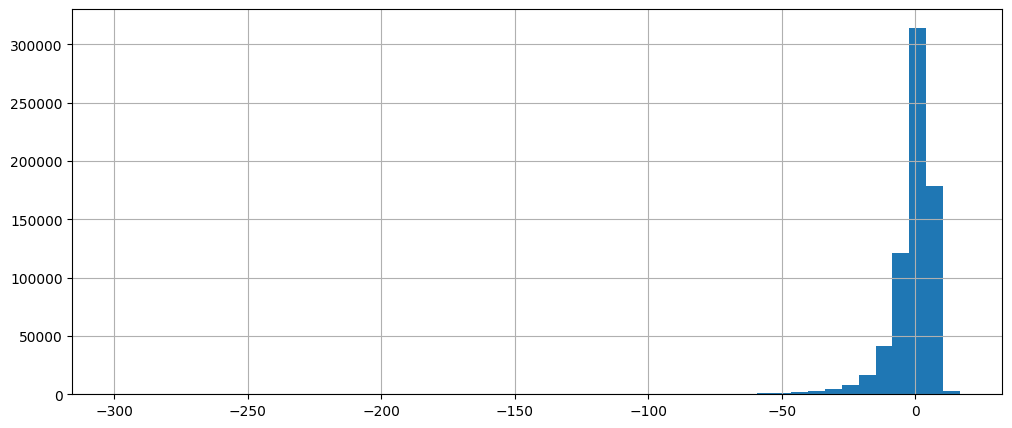

In [21]:
diff = y_pred_rfr - y_strat_test

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

diff.hist(bins=50, figsize=(12, 5))
plt.show()

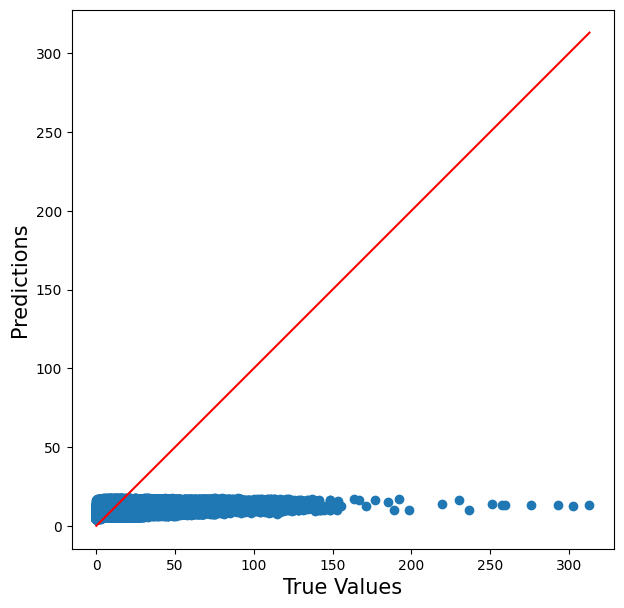

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(y_strat_test, y_pred_rfr)

p1 = max(max(y_pred_rfr), max(y_strat_test))
p2 = min(min(y_pred_rfr), min(y_strat_test))
plt.plot([p1, p2], [p1, p2], 'r')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

c:\Users\Ananya Gyanmote\OneDrive\Desktop\study\DSPS\year3\sem2\thesis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


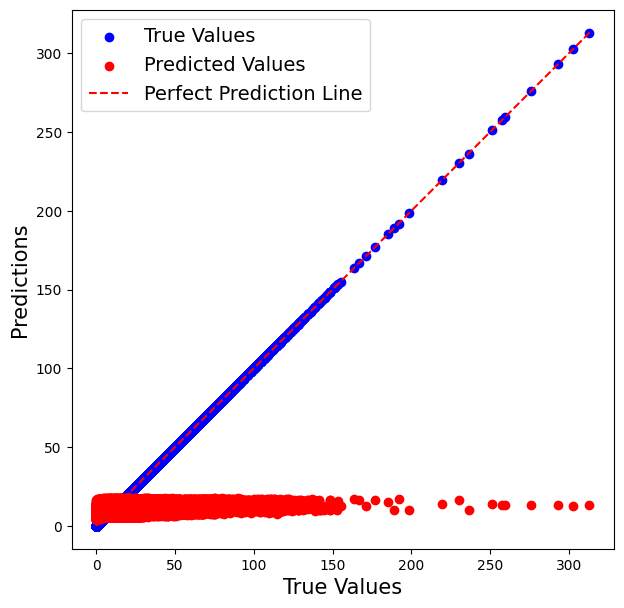

In [23]:
plt.figure(figsize=(7,7))


plt.scatter(y_strat_test, y_strat_test, color='blue', label='True Values')
plt.scatter(y_strat_test, y_pred_rfr, color='red', label='Predicted Values')

# plot prediction line
p1 = max(max(y_pred_rfr), max(y_strat_test))
p2 = min(min(y_pred_rfr), min(y_strat_test))
plt.plot([p1, p2], [p1, p2], 'r--', label='Perfect Prediction Line')

plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.axis('equal')
plt.legend()
plt.show()

### Gradient Boosted Trees

#### LightGBM

In [24]:
train_data = lgb.Dataset(X_train, label=y_train)
validate_data = lgb.Dataset(X_validate, label=y_validate, reference=train_data)

# defining objective function for optuna
def objective(trial):
    # hyperparameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_pre_filter': False,
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
        'random_state': 42
    }

    # train model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, validate_data],
        valid_names=['training', 'valid_0'],
        # pruning to reduce time taken
        callbacks = [lgb.early_stopping(stopping_rounds = 50), lgb.log_evaluation(50), optuna.integration.LightGBMPruningCallback(trial, 'rmse')],
    )

    # predict and calculate rmse
    y_pred = model.predict(X_validate, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_validate, y_pred))
    
    return rmse

##### training

In [25]:
# optimize optuna params
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(f"Best hyperparameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")

[I 2024-08-18 15:33:02,854] A new study created in memory with name: no-name-2ec7aabd-efa6-4a3d-a17d-6a78cc302442


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26897	valid_0's rmse: 8.72775
[100]	training's rmse: 6.26452	valid_0's rmse: 8.72287
[150]	training's rmse: 6.26265	valid_0's rmse: 8.72247
Early stopping, best iteration is:
[144]	training's rmse: 6.26283	valid_0's rmse: 8.7224


[I 2024-08-18 15:33:46,506] Trial 0 finished with value: 8.722399945300744 and parameters: {'learning_rate': 0.08991044778156537, 'num_leaves': 55, 'min_data_in_leaf': 75, 'feature_fraction': 0.9007524364812414, 'bagging_fraction': 0.9351418870614927, 'bagging_freq': 7, 'lambda_l1': 0.16588508575311012, 'lambda_l2': 0.307409539211585}. Best is trial 0 with value: 8.722399945300744.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.284496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26317	valid_0's rmse: 8.7249
[100]	training's rmse: 6.25953	valid_0's rmse: 8.72411
Early stopping, best iteration is:
[70]	training's rmse: 6.26114	valid_0's rmse: 8.7237


[I 2024-08-18 15:34:29,891] Trial 1 finished with value: 8.723703367159258 and parameters: {'learning_rate': 0.09765565423119721, 'num_leaves': 146, 'min_data_in_leaf': 95, 'feature_fraction': 0.9752382442884713, 'bagging_fraction': 0.9912979456143638, 'bagging_freq': 5, 'lambda_l1': 0.42569766161323586, 'lambda_l2': 0.5693339875420307}. Best is trial 0 with value: 8.722399945300744.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26873	valid_0's rmse: 8.72708
[100]	training's rmse: 6.26464	valid_0's rmse: 8.7229
[150]	training's rmse: 6.2626	valid_0's rmse: 8.72248
Early stopping, best iteration is:
[139]	training's rmse: 6.26299	valid_0's rmse: 8.72237


[I 2024-08-18 15:34:58,580] Trial 2 finished with value: 8.72236678397355 and parameters: {'learning_rate': 0.09808349920466726, 'num_leaves': 49, 'min_data_in_leaf': 24, 'feature_fraction': 0.8694041141688975, 'bagging_fraction': 0.8838694744686981, 'bagging_freq': 1, 'lambda_l1': 0.49285014173834896, 'lambda_l2': 0.08924700030389354}. Best is trial 2 with value: 8.72236678397355.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26687	valid_0's rmse: 8.72667
[100]	training's rmse: 6.26278	valid_0's rmse: 8.72301
[150]	training's rmse: 6.26087	valid_0's rmse: 8.72324
Early stopping, best iteration is:
[109]	training's rmse: 6.26233	valid_0's rmse: 8.72293


[I 2024-08-18 15:35:30,831] Trial 3 finished with value: 8.722926593277895 and parameters: {'learning_rate': 0.08711243171844778, 'num_leaves': 83, 'min_data_in_leaf': 72, 'feature_fraction': 0.9999272863400932, 'bagging_fraction': 0.8071874414958804, 'bagging_freq': 10, 'lambda_l1': 0.5986573904790465, 'lambda_l2': 0.16704472514519964}. Best is trial 2 with value: 8.72236678397355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.27741	valid_0's rmse: 8.75967
[100]	training's rmse: 6.26552	valid_0's rmse: 8.72918
[150]	training's rmse: 6.26234	valid_0's rmse: 8.72431
[200]	training's rmse: 6.26075	valid_0's rmse: 8.72359
[250]	training's rmse: 6.25979	valid_0's rmse: 8.72383
Early stopping, best iteration is:
[203]	training's rmse: 6.26069	valid_0's rmse: 8.72357


[I 2024-08-18 15:36:57,196] Trial 4 finished with value: 8.723567541259596 and parameters: {'learning_rate': 0.03680707157860627, 'num_leaves': 147, 'min_data_in_leaf': 90, 'feature_fraction': 0.8741327659057017, 'bagging_fraction': 0.9924499626236742, 'bagging_freq': 5, 'lambda_l1': 0.0035360304369985718, 'lambda_l2': 0.30816906278844913}. Best is trial 2 with value: 8.72236678397355.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:36:57,936] Trial 5 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.299437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:36:58,705] Trial 6 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:36:59,224] Trial 7 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:37:00,061] Trial 8 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:37:00,984] Trial 9 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:37:01,693] Trial 10 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26799	valid_0's rmse: 8.72648


[I 2024-08-18 15:37:23,173] Trial 11 pruned. Trial was pruned at iteration 72.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:37:24,005] Trial 12 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:37:24,823] Trial 13 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:37:25,439] Trial 14 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26659	valid_0's rmse: 8.72574
[100]	training's rmse: 6.26289	valid_0's rmse: 8.72246
[150]	training's rmse: 6.26103	valid_0's rmse: 8.72314
Early stopping, best iteration is:
[123]	training's rmse: 6.26195	valid_0's rmse: 8.72241


[I 2024-08-18 15:38:12,348] Trial 15 finished with value: 8.722408783362738 and parameters: {'learning_rate': 0.09987881131429115, 'num_leaves': 73, 'min_data_in_leaf': 51, 'feature_fraction': 0.8455634597492854, 'bagging_fraction': 0.747218227274366, 'bagging_freq': 3, 'lambda_l1': 0.36436706454857726, 'lambda_l2': 0.10923046546535353}. Best is trial 2 with value: 8.72236678397355.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:38:13,081] Trial 16 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:38:14,131] Trial 17 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:38:15,246] Trial 18 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:38:15,917] Trial 19 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26531	valid_0's rmse: 8.72589


[I 2024-08-18 15:38:44,718] Trial 20 pruned. Trial was pruned at iteration 98.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26699	valid_0's rmse: 8.72567
[100]	training's rmse: 6.26302	valid_0's rmse: 8.72292


[I 2024-08-18 15:39:15,286] Trial 21 pruned. Trial was pruned at iteration 120.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:39:15,989] Trial 22 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:39:16,630] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2024-08-18 15:39:17,133] Trial 24 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26624	valid_0's rmse: 8.7261


[I 2024-08-18 15:39:49,682] Trial 25 pruned. Trial was pruned at iteration 94.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:39:50,318] Trial 26 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26663	valid_0's rmse: 8.72641
[100]	training's rmse: 6.26251	valid_0's rmse: 8.72279
[150]	training's rmse: 6.26038	valid_0's rmse: 8.72298
Early stopping, best iteration is:
[125]	training's rmse: 6.26124	valid_0's rmse: 8.72249


[I 2024-08-18 15:40:40,452] Trial 27 finished with value: 8.722485568292003 and parameters: {'learning_rate': 0.0940692411942832, 'num_leaves': 78, 'min_data_in_leaf': 23, 'feature_fraction': 0.8987965444587702, 'bagging_fraction': 0.9168478299692152, 'bagging_freq': 2, 'lambda_l1': 0.19294912039289414, 'lambda_l2': 0.15910539679414581}. Best is trial 2 with value: 8.72236678397355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:40:41,198] Trial 28 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26511	valid_0's rmse: 8.72529


[I 2024-08-18 15:41:01,210] Trial 29 pruned. Trial was pruned at iteration 93.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:41:01,798] Trial 30 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26653	valid_0's rmse: 8.7263
[100]	training's rmse: 6.26239	valid_0's rmse: 8.72269
[150]	training's rmse: 6.26038	valid_0's rmse: 8.72314
Early stopping, best iteration is:
[102]	training's rmse: 6.2623	valid_0's rmse: 8.72261


[I 2024-08-18 15:41:43,149] Trial 31 finished with value: 8.722613498805638 and parameters: {'learning_rate': 0.09432251631650519, 'num_leaves': 80, 'min_data_in_leaf': 25, 'feature_fraction': 0.8963818626568454, 'bagging_fraction': 0.9178265720317034, 'bagging_freq': 2, 'lambda_l1': 0.19396585240937014, 'lambda_l2': 0.15483570872523078}. Best is trial 2 with value: 8.72236678397355.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:41:43,890] Trial 32 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26772	valid_0's rmse: 8.72651


[I 2024-08-18 15:42:00,048] Trial 33 pruned. Trial was pruned at iteration 58.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:42:00,763] Trial 34 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:42:01,344] Trial 35 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:42:02,044] Trial 36 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:42:02,999] Trial 37 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:42:03,658] Trial 38 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:42:04,331] Trial 39 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26623	valid_0's rmse: 8.72559


[I 2024-08-18 15:42:30,209] Trial 40 pruned. Trial was pruned at iteration 96.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.365441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:42:31,440] Trial 41 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26538	valid_0's rmse: 8.72549
[100]	training's rmse: 6.26126	valid_0's rmse: 8.72291


[I 2024-08-18 15:42:59,463] Trial 42 pruned. Trial was pruned at iteration 111.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:43:00,144] Trial 43 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:43:00,727] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2024-08-18 15:43:01,193] Trial 45 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:43:02,029] Trial 46 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:43:02,710] Trial 47 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:43:03,444] Trial 48 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:43:04,066] Trial 49 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:43:04,821] Trial 50 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26657	valid_0's rmse: 8.72514


[I 2024-08-18 15:43:26,841] Trial 51 pruned. Trial was pruned at iteration 91.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:43:27,506] Trial 52 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:43:28,273] Trial 53 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:43:28,915] Trial 54 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:43:29,510] Trial 55 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:43:30,293] Trial 56 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26518	valid_0's rmse: 8.7252
[100]	training's rmse: 6.26124	valid_0's rmse: 8.72297
Early stopping, best iteration is:
[82]	training's rmse: 6.26225	valid_0's rmse: 8.72248


[I 2024-08-18 15:44:05,190] Trial 57 finished with value: 8.722475054965495 and parameters: {'learning_rate': 0.0969174757094425, 'num_leaves': 100, 'min_data_in_leaf': 75, 'feature_fraction': 0.9201903501721778, 'bagging_fraction': 0.8652983741789022, 'bagging_freq': 2, 'lambda_l1': 0.5521745693098279, 'lambda_l2': 0.49195570094289265}. Best is trial 2 with value: 8.72236678397355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26539	valid_0's rmse: 8.72523
[100]	training's rmse: 6.2615	valid_0's rmse: 8.72286
Early stopping, best iteration is:
[82]	training's rmse: 6.26245	valid_0's rmse: 8.72267


[I 2024-08-18 15:44:47,343] Trial 58 finished with value: 8.722667886752776 and parameters: {'learning_rate': 0.09676150515246601, 'num_leaves': 97, 'min_data_in_leaf': 76, 'feature_fraction': 0.9163170868138436, 'bagging_fraction': 0.8640180494628817, 'bagging_freq': 2, 'lambda_l1': 0.5409219141157571, 'lambda_l2': 0.5924270806672542}. Best is trial 2 with value: 8.72236678397355.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:44:48,225] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2024-08-18 15:44:48,737] Trial 60 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26423	valid_0's rmse: 8.72521


[I 2024-08-18 15:45:23,410] Trial 61 pruned. Trial was pruned at iteration 94.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26529	valid_0's rmse: 8.72554


[I 2024-08-18 15:45:48,362] Trial 62 pruned. Trial was pruned at iteration 77.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:45:49,129] Trial 63 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26519	valid_0's rmse: 8.7249


[I 2024-08-18 15:46:10,689] Trial 64 pruned. Trial was pruned at iteration 92.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:46:11,311] Trial 65 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:46:12,175] Trial 66 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26537	valid_0's rmse: 8.72516
[100]	training's rmse: 6.26143	valid_0's rmse: 8.723


[I 2024-08-18 15:46:35,963] Trial 67 pruned. Trial was pruned at iteration 120.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:46:36,806] Trial 68 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:46:37,831] Trial 69 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.249721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:46:38,725] Trial 70 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds


[I 2024-08-18 15:46:51,053] Trial 71 pruned. Trial was pruned at iteration 32.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:46:51,838] Trial 72 pruned. Trial was pruned at iteration 0.
[I 2024-08-18 15:46:52,353] Trial 73 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:46:53,041] Trial 74 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:46:53,616] Trial 75 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:46:54,223] Trial 76 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26347	valid_0's rmse: 8.72508


[I 2024-08-18 15:47:15,105] Trial 77 pruned. Trial was pruned at iteration 65.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26552	valid_0's rmse: 8.72521
[100]	training's rmse: 6.26152	valid_0's rmse: 8.72299


[I 2024-08-18 15:47:51,817] Trial 78 pruned. Trial was pruned at iteration 120.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:47:53,055] Trial 79 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:47:55,106] Trial 80 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.468139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:47:58,291] Trial 81 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:47:59,425] Trial 82 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:48:01,075] Trial 83 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:48:01,731] Trial 84 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:48:02,762] Trial 85 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:48:03,584] Trial 86 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:48:04,419] Trial 87 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26376	valid_0's rmse: 8.72499


[I 2024-08-18 15:48:25,938] Trial 88 pruned. Trial was pruned at iteration 74.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26635	valid_0's rmse: 8.72608


[I 2024-08-18 15:48:42,125] Trial 89 pruned. Trial was pruned at iteration 76.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:48:42,791] Trial 90 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26304	valid_0's rmse: 8.72472


[I 2024-08-18 15:49:04,906] Trial 91 pruned. Trial was pruned at iteration 70.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.2636	valid_0's rmse: 8.72532


[I 2024-08-18 15:49:30,136] Trial 92 pruned. Trial was pruned at iteration 65.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26312	valid_0's rmse: 8.72516


[I 2024-08-18 15:49:57,576] Trial 93 pruned. Trial was pruned at iteration 69.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:49:58,473] Trial 94 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6.26369	valid_0's rmse: 8.72499


[I 2024-08-18 15:50:25,270] Trial 95 pruned. Trial was pruned at iteration 74.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:50:26,224] Trial 96 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:50:26,824] Trial 97 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:50:27,529] Trial 98 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511


[I 2024-08-18 15:50:28,185] Trial 99 pruned. Trial was pruned at iteration 0.


Best hyperparameters: {'learning_rate': 0.09808349920466726, 'num_leaves': 49, 'min_data_in_leaf': 24, 'feature_fraction': 0.8694041141688975, 'bagging_fraction': 0.8838694744686981, 'bagging_freq': 1, 'lambda_l1': 0.49285014173834896, 'lambda_l2': 0.08924700030389354}
Best RMSE: 8.72236678397355


##### evaluation

In [26]:
# training with best params
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
best_params['random_state'] = 42

final_model_lgbm = lgb.train(
    best_params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, validate_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50)],
)

# saving the model
with open('lightGBM0.1.2.pkl', 'wb')as file:
    pickle.dump(final_model_lgbm, file)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 2170300, number of used features: 36
[LightGBM] [Info] Start training from score 9.310511
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	training's rmse: 6.26299	valid_1's rmse: 8.72237


In [27]:
# evaluate
y_pred_lgbm = final_model_lgbm.predict(X_strat_test, num_iteration=final_model_lgbm.best_iteration)
final_rmse = mean_squared_error(y_strat_test, y_pred_lgbm, squared=False)
print(f"Final RMSE: {final_rmse}")

Final RMSE: 8.749810456492401


c:\Users\Ananya Gyanmote\OneDrive\Desktop\study\DSPS\year3\sem2\thesis\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


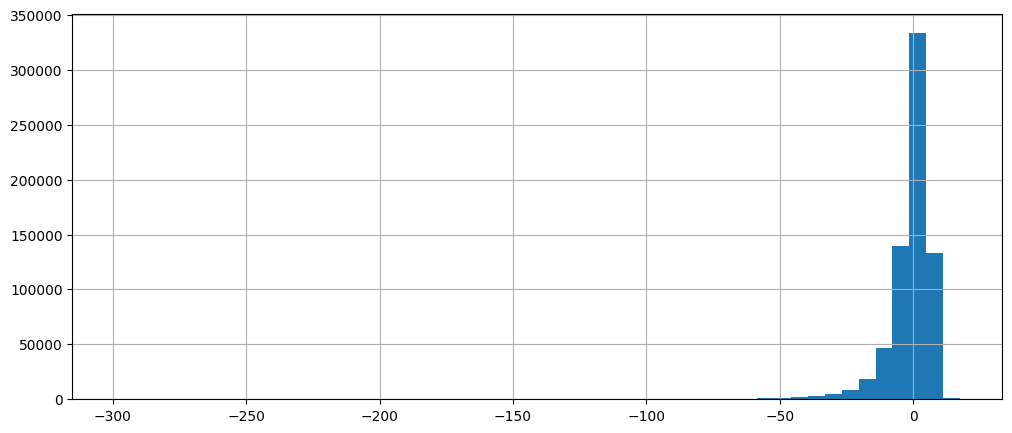

In [30]:
diff = y_pred_lgbm - y_strat_test

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

diff.hist(bins=50, figsize=(12, 5))
plt.show()

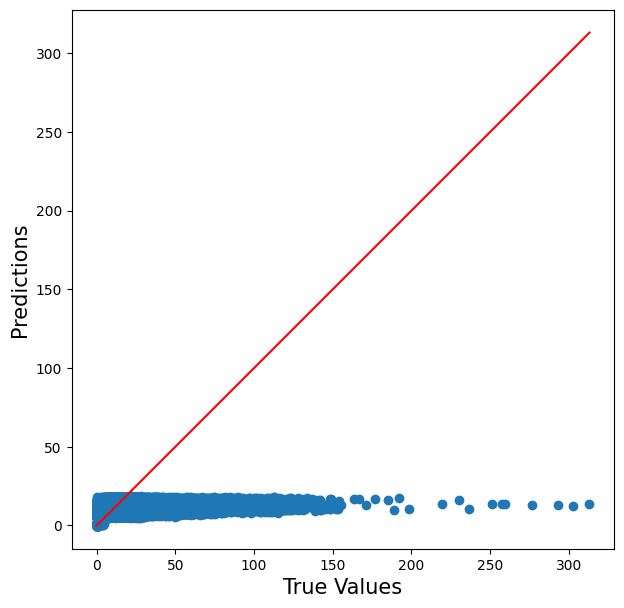

In [31]:
plt.figure(figsize=(7,7))
plt.scatter(y_strat_test, y_pred_lgbm)

p1 = max(max(y_pred_lgbm), max(y_strat_test))
p2 = min(min(y_pred_lgbm), min(y_strat_test))
plt.plot([p1, p2], [p1, p2], 'r')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

c:\Users\Ananya Gyanmote\OneDrive\Desktop\study\DSPS\year3\sem2\thesis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


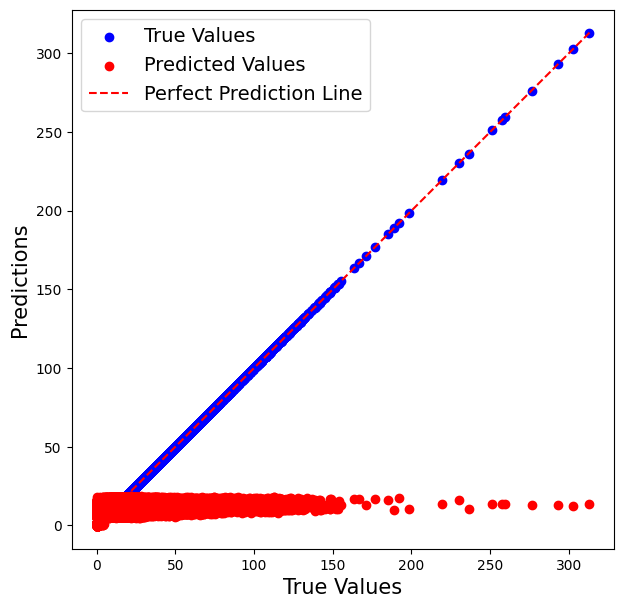

In [32]:
plt.figure(figsize=(7,7))

plt.scatter(y_strat_test, y_strat_test, color='blue', label='True Values')
plt.scatter(y_strat_test, y_pred_lgbm, color='red', label='Predicted Values')

# plot prediction line
p1 = max(max(y_pred_lgbm), max(y_strat_test))
p2 = min(min(y_pred_lgbm), min(y_strat_test))
plt.plot([p1, p2], [p1, p2], 'r--', label='Perfect Prediction Line')

plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.axis('equal')
plt.legend()
plt.show()